In [1]:
import argparse
import sys
import cv2
from ultralytics import YOLO
from djitellopy import Tello
import numpy as np
from pathlib import Path
from boxmot import DeepOCSORT
import time
import math




d:\anaconda\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Configuration
video_out = 'video.mp4'
model_path = './yolo8s.pt'
tracker_weights = './osnet_x0_25_msmt17.pt'
mode = 'camera'

In [3]:
# Initialize Tello Drone or Camera
#tello = Tello()
#tello_connected = False
object_tracking = {}



In [4]:
# Initialize drone connection
def initialize_drone():
    global tello_connected
    try:
        tello.connect()
        tello_connected = True
        print(f"battery: {tello.get_battery()}%")
        tello.streamon()
    except Exception as e: 
        print("Failed to connect to Tello drone. Falling back to local camera.",e)
        tello_connected = False
        if mode == 'tello':
            sys.exit(1)



In [5]:
# Video Writer Setup
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out_writer = cv2.VideoWriter(video_out,fourcc,20,(960, 720), isColor=True)



In [6]:
# Get Frame from Tello or camera
def get_frame():
    frame_source = tello.get_frame_read(with_queue = False, max_queue_len=0) if tello_connected else cv2.VideoCapture(0)
    if tello_connected:
        print('AA')
        # tello.takeoff()
    while True:
        frame = frame_source.frame if tello_connected else frame_source.read()[1]
        print('BB')

        # cv2.imshow('video',frame)
        print('CC')
        if frame is not None:
            yield frame
        else:
            print("No frame Received")



In [7]:
#Process Frame for Detection
def process_frame(frame,model,tracker):
    start_time = time.time()
    results = model(frame, verbose=False)
    # dets = [(box.xyxy.tolist()[0], box.conf.item(), box.cls.item()) for box in results[0].boxes]
    dets = [(*box.xyxy.tolist()[0], box.conf.item(), box.cls.item()) for box in results[0].boxes]
    print('1',dets)
    dets = np.array(dets)
    print('2',dets)

    print(f"dets shape: {dets.shape}")

    if len(dets.shape) ==2:
        print('DD')
        tracker.update(dets,frame)
        tracker.plot_results(frame,show_trajectories = True)
        track_objects(frame,tracker)
    
    end_time = time.time()
    processing_time = end_time-start_time
    print(f"Frame processing time: {processing_time:.2f}seconds")



In [8]:
#Track Objects in the Frame
def track_objects(frame,tracker):
    for a in tracker.active_tracks:
        if len(a.history_observations) < 12:
            continue
        box = a.history_observations[-1][:4]
        track_id = a.id
        annotate_frame(box, track_id,frame)
        add_trajectory_point(track_id, (int((box[0] + box[2])/2),int ((box[1]+box[3])/2)),frame)

# Annotate Frame with Distance and Speed
def annotate_frame(box,track_id,frame):
    x1,y1,x2,y2 = map(int,box)
    distance = get_dist(box,frame,track_id)
    speed, ttc = calculate_speed_and_distance(track_id,distance)
    speed_text = f'Speed: {speed:.2f} cm/s | TTC: {ttc:.2f} s'
    cv2.putText(frame,speed_text, ((x1+x1)//2,y2-20),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)

#Get Distance from Bounding Box
def get_dist(rectangle,image,track_id):
    focal = 450
    object_width = 40
    pixels =rectangle[2]-rectangle[0]
    dist = (object_width*focal)/pixels
    dist_text =f'Distance:{dist:.2f}cm'
    cv2.putText(image,dist_text, (int(rectangle[0]),int(rectangle[1]+10)),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),2)

    if track_id not in object_tracking:
        object_tracking[track_id]=[]
    object_tracking[track_id].append({
        'time':time.time(),
        'bbox':rectangle,
        'speed': None,
        'ttc':None
    })

    if len (object_tracking[track_id])>25:
        object_tracking[track_id] = object_tracking[track_id][-25:]
    return dist


#Calculate Speed and Distance to Collision
def calculate_speed_and_distance(track_id, current_distance):
    tracking_info = object_tracking[track_id]
    if len(tracking_info)>1:
        previous_info = tracking_info[-2]
        current_info = tracking_info[-1]
        t1,d1 = previous_info['time'],previous_info['distance']
        t2,d2 = current_info['time'],current_info['distance']
        speed = -1*(d2-d1)/(t2-t1)
        ttc = d2/speed if speed>0 else float ('inf')
        current_info['speed'] =speed
        current_info['ttc'] =ttc
        return speed,ttc
    return 0, float('inf')

#Draw Trajectory Points
trajectory_points ={}

def add_trajectory_point(track_id,point,frame):
    if track_id not in trajectory_points:
        trajectory_points[track_id] = []
    trajectory_points[track_id].append(point)
    drawPoints(frame,trajectory_points[track_id])

def drawPoints(img,points):
    for point in points:
        cv2.circle(img,point,5,(0,0,255),cv2.FAILED)
        x_meters = (points[-1][0] - 500)/100
        y_meters = (points[-1][1] - 500)/100
        text = f'({x_meters:.2f}m,{y_meters:.2f}m)'
        cv2.putText(img,text,(points[-1][0]+10,points[-1][1]+30),cv2.Font_HERSHEY_PLAIN,1,(255,0,255),1)

#Cleanup Function
def cleanup():
    video_out_writer.release()
    if tello_connected or mode =='tello':
        try:
            tello.streamoff()
        except Exception as e:
            print(f"Error stopping video stream:{e}")
    cv2.destroyAllWindows()

In [9]:

mode = 'camera'
video_out = video_out

initialize_drone()

model=YOLO(r"D:\CSU\#2Fall\Graduate Project\Project Code\yolov8s.pt",task='detect')
tracker = DeepOCSORT(
    model_weights= Path(tracker_weights),
    device = 'cpu',
    fp16=False,
)

try:
    for frame in get_frame():
        process_frame(frame,model,tracker)
        print('EE')
        video_out_writer.write(frame)
        cv2.imshow("YOLOv8 Tello Drone Tracking",frame)
        if cv2.waitKey(1) & 0xFF == ord('x'):
            break
        if mode == 'tello' and not tello_connected:
            break
        break
except Exception as e:
    print(f'Error during running: {e}')
finally:
    cleanup()

2024-11-09 15:45:33.255 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v10.0.77 🚀 Python-3.11.5 torch-2.2.2+cpuCPU


Failed to connect to Tello drone. Falling back to local camera. name 'tello' is not defined


2024-11-09 15:45:33.337 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:183 - Loaded pretrained weights from osnet_x0_25_msmt17.pt


BB
CC
1 [(277.6414794921875, 182.70709228515625, 579.5020751953125, 479.7154541015625, 0.7515333890914917, 0.0), (548.22802734375, 118.16143798828125, 639.396728515625, 477.95538330078125, 0.45397695899009705, 0.0)]
2 [[     277.64      182.71       579.5      479.72     0.75153           0]
 [     548.23      118.16       639.4      477.96     0.45398           0]]
dets shape: (2, 6)
DD
Frame processing time: 2.57seconds
EE


In [10]:
model = YOLO(r"D:\CSU\#2Fall\Graduate Project\Project Code\yolov8s.pt", task='detect')
tracker = DeepOCSORT(
    model_weights=Path(tracker_weights),
    device='cpu',
    fp16=False,
)

2024-11-09 15:45:37.587 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v10.0.77 🚀 Python-3.11.5 torch-2.2.2+cpuCPU
2024-11-09 15:45:37.820 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:183 - Loaded pretrained weights from osnet_x0_25_msmt17.pt


# main

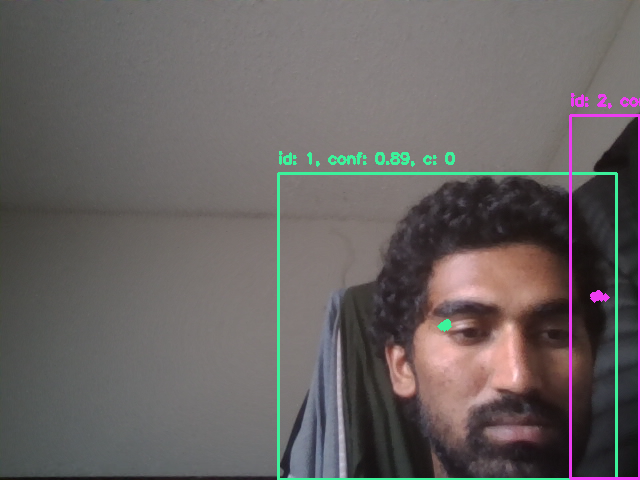

BB
CC
1 [(277.05511474609375, 171.50909423828125, 627.7210083007812, 479.35772705078125, 0.8609259724617004, 0.0), (570.872314453125, 110.14410400390625, 639.473388671875, 478.88238525390625, 0.48087364435195923, 0.0)]
2 [[     277.06      171.51      627.72      479.36     0.86093           0]
 [     570.87      110.14      639.47      478.88     0.48087           0]]
dets shape: (2, 6)
DD
Error during running: module 'cv2' has no attribute 'Font_HERSHEY_PLAIN'


In [11]:
from IPython.display import display, clear_output
from PIL import Image
import cv2

# Set mode to camera
mode = 'camera'
video_out = 'video.mp4'

# Initialize model and tracker

# Get Frame from Tello or camera
def get_frame():
    frame_source = tello.get_frame_read(with_queue = False, max_queue_len=0) if tello_connected else cv2.VideoCapture(0)
    if tello_connected:
        print('AA')
        # tello.takeoff()
    while True:
        frame = frame_source.frame if tello_connected else frame_source.read()[1]
        print('BB')

        # cv2.imshow('video',frame)
        print('CC')
        if frame is not None:
            yield frame
        else:
            print("No frame Received")


#Track Objects in the Frame
def track_objects(frame,tracker):
    for a in tracker.active_tracks:
        if len(a.history_observations) < 12:
            continue
        box = a.history_observations[-1][:4]
        track_id = a.id
        annotate_frame(box, track_id,frame)
        add_trajectory_point(track_id, (int((box[0] + box[2])/2),int ((box[1]+box[3])/2)),frame)

# Annotate Frame with Distance and Speed
def annotate_frame(box,track_id,frame):
    x1,y1,x2,y2 = map(int,box)
    distance = get_dist(box,frame,track_id)
    speed, ttc = calculate_speed_and_distance(track_id,distance)
    speed_text = f'Speed: {speed:.2f} cm/s | TTC: {ttc:.2f} s'
    cv2.putText(frame,speed_text, ((x1+x1)//2,y2-20),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)

#Get Distance from Bounding Box
def get_dist(rectangle,image,track_id):
    focal = 450
    object_width = 40
    pixels =rectangle[2]-rectangle[0]
    dist = (object_width*focal)/pixels
    dist_text =f'Distance:{dist:.2f}cm'
    cv2.putText(image,dist_text, (int(rectangle[0]),int(rectangle[1]+10)),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),2)

    if track_id not in object_tracking:
        object_tracking[track_id]=[]
    object_tracking[track_id].append({
        'time':time.time(),
        'bbox':rectangle,
        'speed': None,
        'ttc':None
    })

    if len (object_tracking[track_id])>25:
        object_tracking[track_id] = object_tracking[track_id][-25:]
    return dist


#Calculate Speed and Distance to Collision
def calculate_speed_and_distance(track_id, current_distance):
    tracking_info = object_tracking[track_id]
    if len(tracking_info)>1:
        previous_info = tracking_info[-2]
        current_info = tracking_info[-1]
        t1,d1 = previous_info['time'],previous_info['distance']
        t2,d2 = current_info['time'],current_info['distance']
        speed = -1*(d2-d1)/(t2-t1)
        ttc = d2/speed if speed>0 else float ('inf')
        current_info['speed'] =speed
        current_info['ttc'] =ttc
        return speed,ttc
    return 0, float('inf')

#Draw Trajectory Points
trajectory_points ={}

def add_trajectory_point(track_id,point,frame):
    if track_id not in trajectory_points:
        trajectory_points[track_id] = []
    trajectory_points[track_id].append(point)
    drawPoints(frame,trajectory_points[track_id])

def drawPoints(img,points):
    for point in points:
        cv2.circle(img, point, 5, (0, 0, 255), thickness=2)
        # cv2.circle(img,point,5,(0,0,255),cv2.FAILED)
        x_meters = (points[-1][0] - 500)/100
        y_meters = (points[-1][1] - 500)/100
        text = f'({x_meters:.2f}m,{y_meters:.2f}m)'
        cv2.putText(img,text,(points[-1][0]+10,points[-1][1]+30),cv2.Font_HERSHEY_PLAIN,1,(255,0,255),1)

#Cleanup Function
def cleanup():
    video_out_writer.release()
    if tello_connected or mode =='tello':
        try:
            tello.streamoff()
        except Exception as e:
            print(f"Error stopping video stream:{e}")
    cv2.destroyAllWindows()

count = 0 
try:
    for frame in get_frame():
        #Process Frame for Detection
        def process_frame(frame,model,tracker):
            start_time = time.time()
            results = model(frame, verbose=False)
            # dets = [(box.xyxy.tolist()[0], box.conf.item(), box.cls.item()) for box in results[0].boxes]
            dets = [(*box.xyxy.tolist()[0], box.conf.item(), box.cls.item()) for box in results[0].boxes]
            print('1',dets)
            dets = np.array(dets)
            print('2',dets)

            print(f"dets shape: {dets.shape}")

            if len(dets.shape) ==2:
                print('DD')
                tracker.update(dets,frame)
                tracker.plot_results(frame,show_trajectories = True)
                track_objects(frame,tracker)
            
            end_time = time.time()
            processing_time = end_time-start_time
            print(f"Frame processing time: {processing_time:.2f}seconds")
        # Process the frame with model and tracker
        process_frame(frame, model, tracker)
        
        # Save the frame to the video output file
        video_out_writer.write(frame)
        
        # Convert the frame (in BGR format) to RGB format and display in notebook
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display_frame = Image.fromarray(rgb_frame)
        
        # Clear previous frame display and show the new frame
        clear_output(wait=True)
        display(display_frame)

        # Break if a certain key is pressed, here it's 'x'
        if cv2.waitKey(1) & 0xFF == ord('x'):
            break
        if mode == 'tello' and not tello_connected:
            break
        count+=1
        if (count > 20):
            break
        

except Exception as e:
    print(f'Error during running: {e}')
finally:
    cleanup()


# main 2

In [17]:
from IPython.display import display, clear_output
from PIL import Image
import cv2

# Set mode to camera
mode = 'camera'
video_out = 'video.mp4'

# Initialize model and tracker

# Get Frame from Tello or camera
def get_frame():
    frame_source = tello.get_frame_read(with_queue = False, max_queue_len=0) if tello_connected else cv2.VideoCapture(0)
    # if tello_connected:
        #print('AA')
        # tello.takeoff()
    while True:
        frame = frame_source.frame if tello_connected else frame_source.read()[1]
        print('BB')

        # cv2.imshow('video',frame)
        print('CC')
        if frame is not None:
            yield frame
        else:
            print("No frame Received")


#Track Objects in the Frame
def track_objects(frame,tracker):
    for a in tracker.active_tracks:
        if len(a.history_observations) < 12:
            continue
        box = a.history_observations[-1][:4]
        track_id = a.id
        annotate_frame(box, track_id,frame)
        add_trajectory_point(track_id, (int((box[0] + box[2])/2),int ((box[1]+box[3])/2)),frame)

# Annotate Frame with Distance and Speed
def annotate_frame(box,track_id,frame):
    x1,y1,x2,y2 = map(int,box)
    distance = get_dist(box,frame,track_id)
    speed, ttc = calculate_speed_and_distance(track_id,distance)
    speed_text = f'Speed: {speed:.2f} cm/s | TTC: {ttc:.2f} s'
    cv2.putText(frame,speed_text, ((x1+x1)//2,y2-20),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)

#Get Distance from Bounding Box
def get_dist(rectangle,image,track_id):
    focal = 450
    object_width = 40
    pixels =rectangle[2]-rectangle[0]
    dist = (object_width*focal)/pixels
    dist_text =f'Distance:{dist:.2f}cm'
    cv2.putText(image,dist_text, (int(rectangle[0]),int(rectangle[1]+10)),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),2)

    if track_id not in object_tracking:
        object_tracking[track_id]=[]
    object_tracking[track_id].append({
        'time':time.time(),
        'bbox':rectangle,
        'distance': dist,
        'speed': None,
        'ttc':None
    })

    if len (object_tracking[track_id])>25:
        object_tracking[track_id] = object_tracking[track_id][-25:]
    return dist


#Calculate Speed and Distance to Collision
def calculate_speed_and_distance(track_id, current_distance):
    tracking_info = object_tracking[track_id]
    if len(tracking_info)>1:
        previous_info = tracking_info[-2]
        current_info = tracking_info[-1]
        print(previous_info.keys(),current_info.keys())
        t1,d1 = previous_info['time'],previous_info['distance']
        t2,d2 = current_info['time'],current_info['distance']
        speed = -1*(d2-d1)/(t2-t1)
        ttc = d2/speed if speed>0 else float ('inf')
        current_info['speed'] =speed
        current_info['ttc'] =ttc
        return speed,ttc
    return 0, float('inf')

#Draw Trajectory Points
trajectory_points ={}

def add_trajectory_point(track_id,point,frame):
    if track_id not in trajectory_points:
        trajectory_points[track_id] = []
    trajectory_points[track_id].append(point)
    drawPoints(frame,trajectory_points[track_id])

def drawPoints(img,points):
    for point in points:
        cv2.circle(img,point,5,(0,0,255), thickness=2)#,cv2.FAILED)
        x_meters = (points[-1][0] - 500)/100
        y_meters = (points[-1][1] - 500)/100
        text = f'({x_meters:.2f}m,{y_meters:.2f}m)'
        cv2.putText(img,text,(points[-1][0]+10,points[-1][1]+30),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),1)

#Cleanup Function
def cleanup():
    video_out_writer.release()
    if tello_connected or mode =='tello':
        try:
            tello.streamoff()
        except Exception as e:
            print(f"Error stopping video stream:{e}")
    cv2.destroyAllWindows()

count = 0 
for frame in get_frame():
    #Process Frame for Detection
    start_time = time.time()
    results = model(frame, verbose=False)
    # print(type(results),len(results),type(results[0]),results[0],results[0].boxes)
    print("FF")
    print(len(results[0].boxes))
    break
    # dets = [(box.xyxy.tolist()[0], box.conf.item(), box.cls.item()) for box in results[0].boxes]
    dets = [(*box.xyxy.tolist()[0], box.conf.item(), box.cls.item()) for box in results[0].boxes]
    print('1',dets)
    dets = np.array(dets)
    print('2',dets)

    print(f"dets shape: {dets.shape}")

    if len(dets.shape) ==2:
        print('DD')
        tracker.update(dets,frame)
        tracker.plot_results(frame,show_trajectories = True)
        track_objects(frame,tracker)
    
    end_time = time.time()
    processing_time = end_time-start_time
    print(f"Frame processing time: {processing_time:.2f}seconds")
    # Process the frame with model and tracker
    
    
    # Save the frame to the video output file
    video_out_writer.write(frame)
    
    # Convert the frame (in BGR format) to RGB format and display in notebook
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    display_frame = Image.fromarray(rgb_frame)
    
    # Clear previous frame display and show the new frame
    clear_output(wait=True)
    display(display_frame)

    # Break if a certain key is pressed, here it's 'x'
    if cv2.waitKey(1) & 0xFF == ord('x'):
        break
    if mode == 'tello' and not tello_connected:
        break
    count+=1
    if (count > 200):
        break
    


cleanup()


BB
CC
FF
2


# end -1

In [13]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

if (cap.isOpened() == False):
    print("Unable to read camera feed")


out = cv2.VideoWriter("a.mp4",fourcc,20,(960, 720), isColor=True)
count = 0
while(True):
    ret,frame = cap.read()
    if ret == True:
        out.write(frame)
        cv2.imshow('frame',frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    count+=1
    if (count > 200):
        break
cap.release()
cv2.destroyAllWindows()

In [14]:
import cv2
import numpy as np

# Initialize video capture from the laptop camera
cap = cv2.VideoCapture(0)

# Check if the camera opened successfully
if not cap.isOpened():
    print("Unable to read camera feed")
    cap.release()
else:
    # Define the codec and create a VideoWriter object to save the output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' for MP4 format
    out = cv2.VideoWriter("a.mp4", fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))), isColor=True)

    count = 0
    while True:
        ret, frame = cap.read()
        
        if ret:
            # Write the frame to the output video file
            out.write(frame)

            # Display the frame (for visualization purposes)
            cv2.imshow('frame', frame)

            # Press 'q' to exit the loop early
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
        
        # Stop after 200 frames
        count += 1
        if count > 200:
            break

    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()


# end

##  add voice

In [15]:
!pip install pyaudio


In [16]:
import cv2
import numpy as np
import pyaudio
import wave
import threading
import time
import subprocess

# Settings
video_file = "video_output.mp4"
audio_file = "audio_output.wav"
output_file = "final_output.mp4"

# Initialize OpenCV video capture
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Unable to read camera feed")
    cap.release()
    exit()

# Video Writer setup
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_file, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))), isColor=True)

# PyAudio configuration
audio_format = pyaudio.paInt16  # 16-bit resolution
channels = 1                    # Mono audio
rate = 44100                    # 44.1kHz sample rate
chunk = 1024                    # 2^10 samples per chunk

# Initialize PyAudio
audio = pyaudio.PyAudio()
stream = audio.open(format=audio_format, channels=channels,
                    rate=rate, input=True, frames_per_buffer=chunk)

# Lists to store audio frames
frames = []

# Function to record audio
def record_audio():
    print("Recording audio...")
    while recording:
        data = stream.read(chunk)
        frames.append(data)

# Start audio recording in a separate thread
recording = True
audio_thread = threading.Thread(target=record_audio)
audio_thread.start()

# Capture video
try:
    count = 0
    while True:
        ret, frame = cap.read()
        
        if ret:
            out.write(frame)
            cv2.imshow('frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
        
        # Stop after 200 frames for testing
        count += 1
        if count > 200:
            break

finally:
    # Stop recording audio
    recording = False
    audio_thread.join()

    # Release resources
    cap.release()
    out.release()
    stream.stop_stream()
    stream.close()
    audio.terminate()
    cv2.destroyAllWindows()

    # Save audio file
    wf = wave.open(audio_file, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(audio.get_sample_size(audio_format))
    wf.setframerate(rate)
    wf.writeframes(b''.join(frames))
    wf.close()

    # Combine audio and video using ffmpeg
    print("Combining audio and video...")
    ffmpeg_command = [
        'ffmpeg', '-y', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', output_file
    ]
    subprocess.run(ffmpeg_command)

    print(f"Video with audio saved as {output_file}")


Recording audio...
Combining audio and video...


FileNotFoundError: [WinError 2] The system cannot find the file specified